In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [ ]:

!unzip 11.zip

Archive:  11.zip
  inflating: 11/newsample_submission.csv  
  inflating: 11/newtest_identity.csv  
  inflating: 11/newtest_transaction_withoutlabel.csv  
  inflating: 11/newtrain_identity.csv  
  inflating: 11/newtrain_transaction_200000.csv  


In [ ]:
%%time
train_transaction = pd.read_csv('/content/11/newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/content/11/newtest_transaction_withoutlabel.csv', index_col='TransactionID')

train_identity = pd.read_csv('/content/11/newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('/content/11/newtest_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('/content/11/newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

(80397, 433)
(10000, 432)
CPU times: user 3.67 s, sys: 404 ms, total: 4.07 s
Wall time: 4.1 s


In [ ]:
X_test_filter = X_test.copy()
X_train_filter = X_train.copy()


### drop all the NaN columns
### dropna() - 
for column in X_test_filter.columns:
    if pd.isnull(X_test_filter[column].unique()[0]):
        X_train_filter.drop([column], axis = 1, inplace=True)
        X_test_filter.drop([column], axis = 1, inplace=True)

In [ ]:
# Label Encoding
def label_encoding(X_train, X_test):
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    return X_train, X_test

In [ ]:
X_train_filter_, X_test_filter_ = label_encoding(X_train_filter, X_test_filter)

In [ ]:
def fill_na_df(X_train, X_test):
    for col_name in X_train.columns: 
        X_train[col_name].fillna(X_train[col_name].mode()[0], inplace=True)
        X_test[col_name].fillna(X_test[col_name].mode()[0], inplace=True)

In [ ]:
X_train_filter_fill = X_train_filter_.copy()
X_test_filter_fill = X_test_filter_.copy()
fill_na_df(X_train_filter_fill, X_test_filter_fill)

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
%%time
X_train_filter_fill = reduce_mem_usage(pd.DataFrame(X_train_filter_fill))
X_test_filter_fill = reduce_mem_usage(pd.DataFrame(X_test_filter_fill))

Memory usage of dataframe is 141.12 MB
Memory usage after optimization is: 39.69 MB
Decreased by 71.9%
Memory usage of dataframe is 17.55 MB
Memory usage after optimization is: 4.89 MB
Decreased by 72.1%
CPU times: user 4.46 s, sys: 82.8 ms, total: 4.54 s
Wall time: 4.56 s


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train_filter_fill = sc.fit_transform(X_train_filter_fill)
X_test_filter_fill = sc.fit_transform(X_test_filter_fill)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_filter_fill, y_train, test_size=0.1, random_state=1)
X_train = np.array(X_train2)
y_train = np.array(Y_train2)
X_test = np.array(X_test2)
y_test = np.array(Y_test2)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=4, weights="distance", p=1)
clf_knn.fit(X_train, y_train)

y_predict_knn = clf_knn.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_predict_knn)

0.6830540555586483

In [ ]:
accuracy_score(y_test, y_predict_knn)

0.9786069651741294

In [ ]:
precision_recall_fscore_support(y_test, y_predict_knn, average=None)

(array([0.98171039, 0.75892857]),
 array([0.99654289, 0.36956522]),
 array([0.98907104, 0.49707602]),
 array([7810,  230]))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr_knn,tpr_knn,threshold_knn = roc_curve(y_test, y_predict_knn) # calculate false positive and true positive
roc_auc_knn = auc(fpr_knn,tpr_knn) # auc

# SVM

In [ ]:
from sklearn import svm

clf_SVM = svm.SVC()
clf_SVM.fit(X_train, y_train)
y_predict_svm=clf_SVM.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_predict_svm)

0.5889383733229416

In [ ]:
accuracy_score(y_test, y_predict_svm)

0.9761194029850746

In [ ]:
precision_recall_fscore_support(y_test, y_predict_svm, average=None)

(array([0.97636318, 0.93181818]),
 array([0.99961588, 0.17826087]),
 array([0.98785271, 0.29927007]),
 array([7810,  230]))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_svm,tpr_svm,threshold_svm = roc_curve(y_test, y_predict_svm) # calculate false positive and true positive
roc_auc_svm = auc(fpr_svm,tpr_svm) # auc

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_depth=5)
clf_dt.fit(X_train, y_train)
y_predict_dt=clf_dt.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_predict_dt)

0.6017257696375883

In [ ]:
accuracy_score(y_test, y_predict_dt)

0.9763681592039801

In [ ]:
precision_recall_fscore_support(y_test, y_predict_dt, average=None)

(array([0.9770849 , 0.87037037]),
 array([0.99910371, 0.20434783]),
 array([0.98797164, 0.33098592]),
 array([7810,  230]))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_dt,tpr_dt,threshold_dt = roc_curve(y_test, y_predict_dt) # calculate false positive and true positive
roc_auc_dt = auc(fpr_dt,tpr_dt) # auc

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
## Trainning - Random Forest
RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators= 200, random_state=42)
clf_rf.fit(X_train, y_train)
y_predict_rf = clf_rf.predict(X_test)

In [ ]:
import math
results = []
threshold_options = list(np.arange (0.01, 0.16, 0.01))

for threshold in threshold_options:
    pred = [math.ceil(x) if x > threshold else 0 for x in y_predict_rf]
    acc_rf = accuracy_score(y_test, pred) # accuracy
    auroc_rf = roc_auc_score(y_test, pred) # auroc

    results.append([threshold, acc_rf, auroc_rf])

In [ ]:
acc_rf

0.9743781094527363

In [ ]:
auroc_rf

0.8391193007849469

In [ ]:
precision_recall_fscore_support(y_test, pred, average=None)

(array([0.99096074, 0.54054054]),
 array([0.98258643, 0.69565217]),
 array([0.98675582, 0.60836502]),
 array([7810,  230]))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_rf,tpr_rf,threshold_rf = roc_curve(y_test, pred) # calculate false positive and true positive
roc_auc_rf = auc(fpr_rf,tpr_rf) # auc

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## Trainning - Adaboost
clf_adb = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200)
clf_adb.fit(X_train, y_train)
y_predict_adb = clf_adb.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_predict_adb)

0.6430301174636753

In [ ]:
accuracy_score(y_test, y_predict_adb)

0.9787313432835821

In [ ]:
precision_recall_fscore_support(y_test, y_predict_adb, average=None)

(array([0.97941509, 0.90410959]),
 array([0.99910371, 0.28695652]),
 array([0.98916144, 0.43564356]),
 array([7810,  230]))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_adb,tpr_adb,threshold_adb = roc_curve(y_test, y_predict_adb) # calculate false positive and true positive
roc_auc_adb = auc(fpr_adb,tpr_adb) # auc

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

clf_gb = GradientBoostingRegressor(max_depth=2, n_estimators=1000, learning_rate=1.0)
clf_gb.fit(X_train, y_train)
y_predict_gb=clf_gb.predict(X_test)

In [ ]:
import math
results = []
threshold_options = list(np.arange (0.01, 0.16, 0.01))

for threshold in threshold_options:
    pred_gb = [math.ceil(x) if x > threshold else 0 for x in y_predict_gb]
    acc_gb = accuracy_score(y_test, pred_gb) # accuracy
    auroc_gb = roc_auc_score(y_test, pred_gb) # auroc

    results.append([threshold, acc_gb, auroc_gb])

In [ ]:
acc_gb

0.9610696517412936

In [ ]:
auroc_gb

0.8124327784891164

In [ ]:
precision_recall_fscore_support(y_test, pred_gb, average=None)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.9894641, 0.375    , 0.       , 0.       ]),
 array([0.97400768, 0.52173913, 0.        , 0.        ]),
 array([0.98167505, 0.43636364, 0.        , 0.        ]),
 array([7810,  230,    0,    0]))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_gb,tpr_gb,threshold_gb = roc_curve(y_test, pred_gb) # calculate false positive and true positive
roc_auc_gb = auc(fpr_gb,tpr_gb) # auc

# XGBoost

In [ ]:
import os
from xgboost import XGBClassifier

## Training - XGBT
clf_xgbt = XGBClassifier()
clf_xgbt.fit(X_train, y_train)
pred_XGBT = clf_xgbt.predict(X_test)
y_predict_xgbt = [round(value) for value in pred_XGBT]

In [ ]:
roc_auc_score(y_test, y_predict_xgbt)

0.6213550075154483

In [ ]:
precision_recall_fscore_support(y_test, y_predict_xgbt, average=None)

(array([0.97819002, 0.90322581]),
 array([0.99923175, 0.24347826]),
 array([0.98859894, 0.38356164]),
 array([7810,  230]))

<Figure size 3600x2400 with 0 Axes>

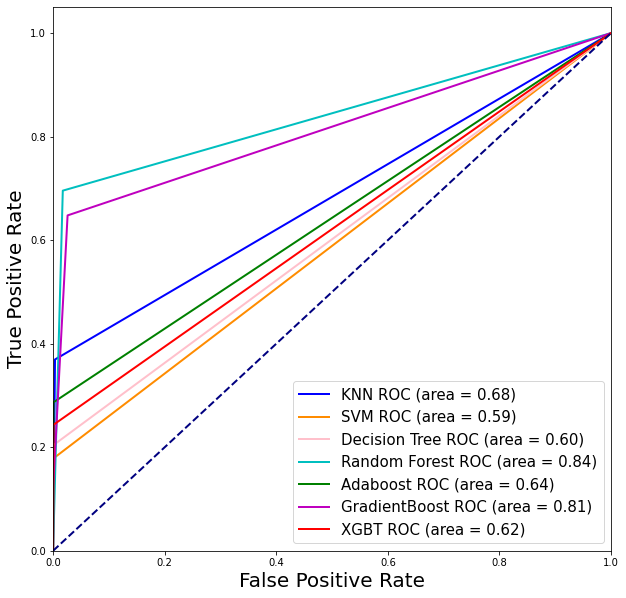

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_xgbt,tpr_xgbt,threshold_xgbt = roc_curve(y_test, y_predict_xgbt) # calculate false positive and true positive
roc_auc_xgbt = auc(fpr_xgbt,tpr_xgbt) # auc



plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr_knn, tpr_knn, color='b',
         lw=lw, label='KNN ROC (area = %0.2f)' % roc_auc_knn) 
plt.plot(fpr_svm, tpr_svm, color='darkorange',
         lw=lw, label='SVM ROC (area = %0.2f)' % roc_auc_svm) 
plt.plot(fpr_dt, tpr_dt, color='pink',
         lw=lw, label='Decision Tree ROC (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='c',
         lw=lw, label='Random Forest ROC (area = %0.2f)' % roc_auc_rf) 
plt.plot(fpr_adb, tpr_adb, color='g',
         lw=lw, label='Adaboost ROC (area = %0.2f)' % roc_auc_adb) 
plt.plot(fpr_gb, tpr_gb, color='m',
         lw=lw, label='GradientBoost ROC (area = %0.2f)' % roc_auc_gb) 
plt.plot(fpr_xgbt, tpr_xgbt, color='r',
         lw=lw, label='XGBT ROC (area = %0.2f)' % roc_auc_xgbt) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize=15)

plt.savefig('ROC_600.png', dpi=600)
plt.savefig('ROC_150.png', dpi=150)